# Numerical exploration of the distribution moments for mRNA and protein.

(c) 2017 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

In [2]:
import glob
import cloudpickle
import os

# Our numerical workhorses
import numpy as np
import scipy as sp
import pandas as pd

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

figdir = '../../fig/chemical_master_moments/'
tmpdir = '../../tmp/'

# $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{fano}{\text{fano-factor}}$
$\newcommand{Var}{\text{Var}}$

## Exploring the mRNA and protein distribution moments

Now that we have computed the mRNA and protein distribution moments for the two- and the three-state promoter let's numerically explore the analytical results.

### Import `lambdify` functions using `cloudpickle`.

When the analytical results were derived we generated `lambdify` functions to explore these results numerically and export them into a file using the `cloudpickle` library. Let's now import these functions into this notebook to make use of them.

In [3]:
# Unregulated two-state promoter
# Parameters are feed in the following order:
# (kp_on, kp_off, rm, gm, rp, gp)
with open('./two_state_moments_lambdify.dill', 'rb') as file:
    mom_unreg_dict = cloudpickle.load(file)
    
# Regulated three-state promoter
# Parameters are feed in the following order:
# (kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)
with open('./three_state_moments_lambdify.dill', 'rb') as file:
    mom_reg_dict = cloudpickle.load(file)

## Defining fano-factor and $\eta^2$ function.

Two interesting quantities is worth exploring is the fano-factor (variance / mean) and the noise-square function $\eta^2$ (variance / mean$^2$). Each of them have their experimental and theoretical advantages.

Specifically the fano-factor is a good metric that can tell us how "non-Poissonian" a distribution is as we expect this quantity to be 1 for the case of a Poisson distribution. If one measures absolute number of molecules the fano-factor is dimensionless because both the variance and the mean have no units (counts of *something* is not a unit). This is useful for example if one is able to count mRNA per cell using single molecule mRNA FISH or some protein counting technique. But if one measures fluorescence in a microscope without a conversion between arbitrary units of fluorescence (a.u.) and absolute molecule count the fano-factor presents theoretical complications. 

To see this let $N$ be the number of molecules counted, then if the relationship between arbitrary units and these count is linear we have that the intensity $I$ of a cell with $N$ molecules is given by
$$
I = \alpha N,
\label{calib_factor}
$$
where $\alpha = \left[{\text{a.u.} \over \text{molecule count}} \right]$ is the conversion factor between units of fluorescence and molecule count.
The fano factor is then of the form
$$
\fano = {\text{Var}(N) \over \ee{N}}.
$$
Using Eq. \ref{calib_factor} we have
$$
\fano = {\Var(I \alpha^{-1}) \over \ee{I \alpha^{-1}}}.
$$
Since $\Var(a x) = a^2 \Var(x)$ for $a =$ constant we have that
$$
\fano = {\alpha^{-2}\Var(I) \over \alpha^{-1}\ee{I}} =
{\Var(I) \over \alpha \ee{I}},
$$
which is not a dimensionless parameter since it depends on $\alpha$.

On the other hand the noise-squared $\eta^2$ is a dimensionless quantity that does not depend on the calibration factor $\alpha$. This is easy to see if we write
$$
\eta^2 \equiv {\Var(N) \over \ee{N}^2} = 
{\Var(I \alpha^{-1}) \over \ee{I \alpha^{-1}}^2},
$$
which can be simplified to
$$
\eta^2 = {\alpha^{-2}\Var(I) \over (\alpha^{-1}\ee{I})^2} = 
\Var{I} \over \ee{I}^2.
$$
Since the units in the numerator and the denominator cancel this is a dimensionless quantity.

## Two-state unregulated promoter.

Let's define a function that computes these quantities for the two-state unregulated promoter.

In [4]:
def fano_unreg(kp_on, kp_off, rm, gm, rp, gp, mRNA=True):
    '''
    Computes the fano-factor (variance / mean) for a two-state unregulated 
    promoter at the mRNA level
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    mRNA : bool. Default = True
        Boolean indicating if it should be computed for the mRNA level.
        If false it is computed for the protein level
    Returns
    -------
    mRNA fano-factor for an unregulated promoter.
    '''
    par = [kp_on, kp_off, rm, gm, rp, gp]
    
    if mRNA:
        return (mom_unreg_dict[(2, 0)](*par) -
                mom_unreg_dict[(1, 0)](*par)**2) / mom_unreg_dict[(1, 0)](*par)
    else:
        return (mom_unreg_dict[(0, 2)](*par) -
                mom_unreg_dict[(0, 1)](*par)**2) / mom_unreg_dict[(1, 0)](*par)


def noise_square_unreg(kp_on, kp_off, rm, gm, rp, gp, mRNA=True):
    '''
    Computes the fano-factor (variance / mean**2) for a two-state unregulated 
    promoter at the mRNA level
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    mRNA : bool. Default = True
        Boolean indicating if it should be computed for the mRNA level.
        If false it is computed for the protein level
    Returns
    -------
    mRNA fano-factor for an unregulated promoter.
    '''
    par = [kp_on, kp_off, rm, gm, rp, gp]
    
    if mRNA:
        return (mom_unreg_dict[(2, 0)](*par) -
                mom_unreg_dict[(1, 0)](*par)**2) / mom_unreg_dict[(0, 1)](*par)**2
    else:
        return (mom_unreg_dict[(0, 2)](*par) -
                mom_unreg_dict[(0, 1)](*par)**2) / mom_unreg_dict[(0, 1)](*par)**2

Let's now list the parameters fit for the *lacUV5* unregulated promoter.

In [5]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6, gm=1)

# define protein degradation rate in units of mRNA degradation rate
gp = 0.000277 / 0.00284 
par_UV5['gp'] = gp

# define rp based on the mean protein copy number per mRNA
par_UV5['rp'] = 1000 * par_UV5['gp']

An interesting quantity to explore is how the noise would vary as the RNAP binding energy, encoded in the $\kpoff$ rate in the kinetic language is varied. But rather than plotting it as a function of this parameter we will plot it as a function of the mean.

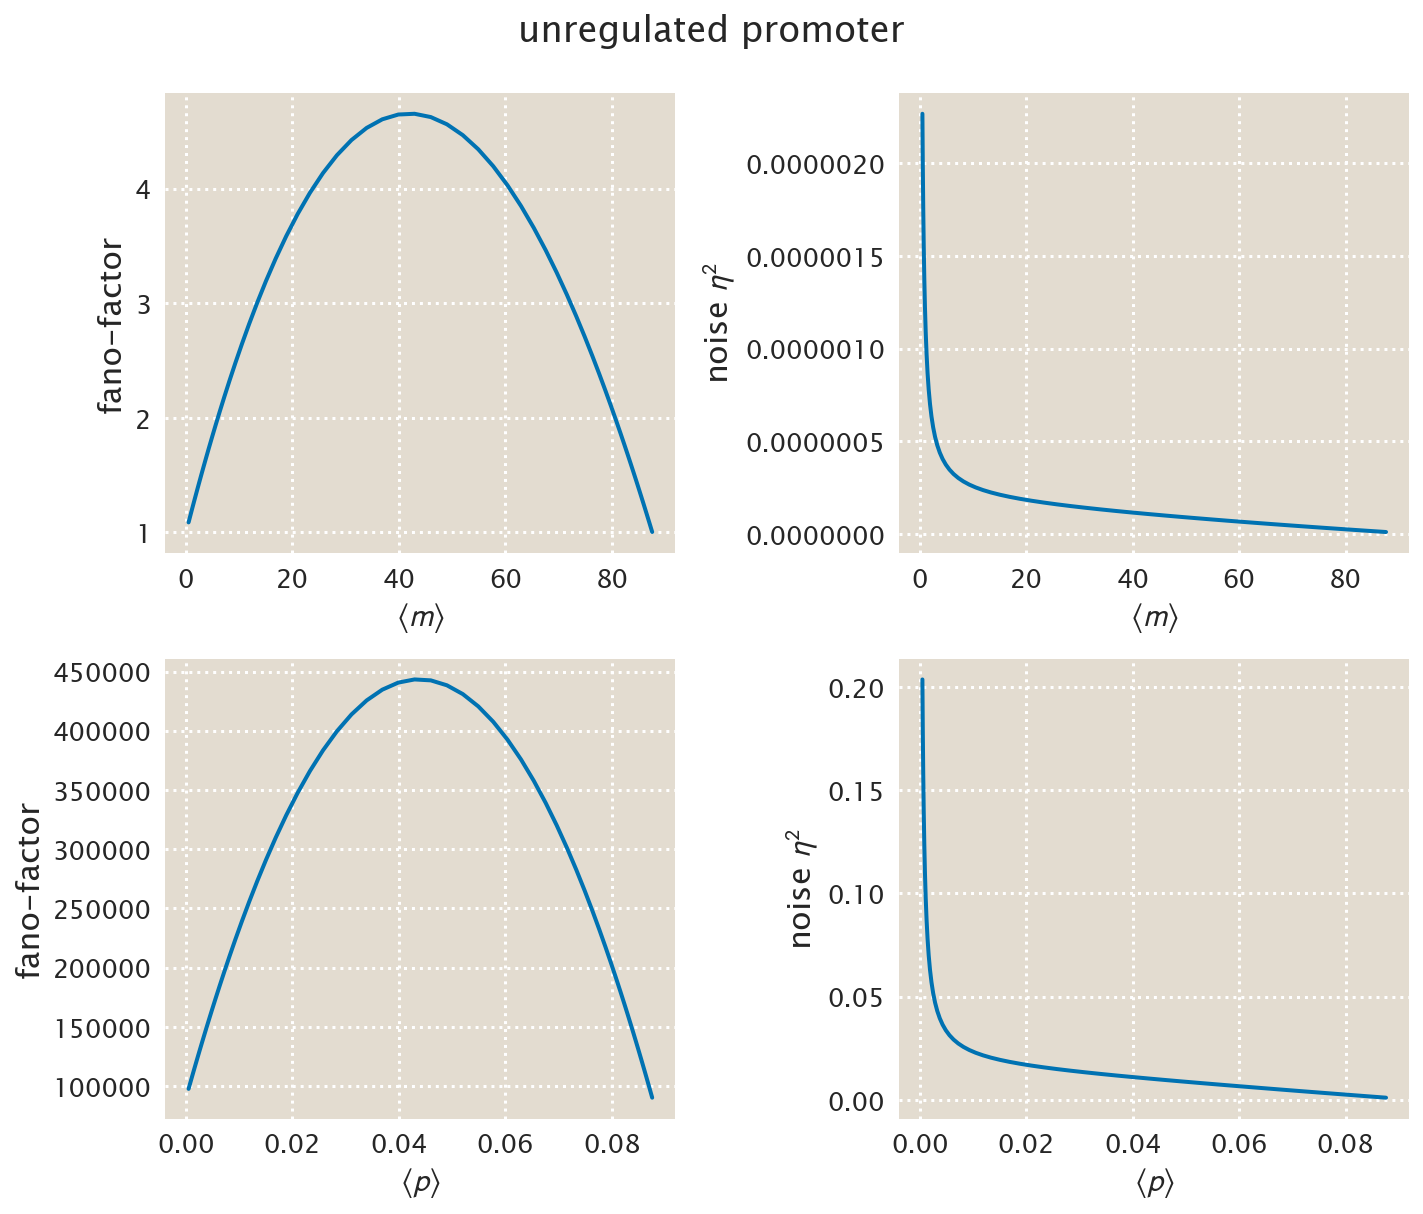

In [14]:
# List array of kpoff values to plot
kp_off_array = np.logspace(-3, 3, 100)
# Copy the dictionary for the lacUV5 promoter
par = par_UV5.copy()
# Change the kp_off value to an array
par['kp_off'] = kp_off_array

# Initialize figure
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax = ax.ravel()

# Plot the fano factor as a function of the mean mRNA
ax[0].plot(mom_unreg_dict[(1, 0)](*par.values()), fano_unreg(**par))
ax[0].set_xlabel(r'$\left\langle m \right\rangle$')
ax[0].set_ylabel('fano-factor')

ax[1].plot(mom_unreg_dict[(1, 0)](*par.values()), noise_square_unreg(**par))
ax[1].set_xlabel(r'$\left\langle m \right\rangle$')
ax[1].set_ylabel('noise $\eta^2$')

# Plot the fano factor as a function of the mean mRNA
ax[2].plot(mom_unreg_dict[(0, 1)](*par.values()), fano_unreg(mRNA=False, **par))
ax[2].set_xlabel(r'$\left\langle p \right\rangle$')
ax[2].set_ylabel('fano-factor')

ax[3].plot(mom_unreg_dict[(0, 1)](*par.values()), 
           noise_square_unreg(mRNA=False, **par))
ax[3].set_xlabel(r'$\left\langle p \right\rangle$')
ax[3].set_ylabel('noise $\eta^2$')


fig.suptitle('unregulated promoter', **{'y': 1.05, 'fontsize':18})
plt.tight_layout()

### Compare two-state promoter protein noise with Shahrezaei & Swain

The noise-squared $\eta^2$ in gene expression defined as
$$
\eta^2 \equiv {Var(\text{gene expression}) \over \ee{\text{gene expression}}^2},
$$
has the advantage of being an adimensional quantity. The fano-factor is adimensional only if the mean and standard deviation are measured in "counts" of molecules. But for the case of microscopy for example there is an arbitrary unit (a.u.) involved that is not canceled when using the fano factor. 


Shahrezaei & Swain in their 2008 paper derived an expression for the noise in protein copy numbers of the form
\begin{equation}
\eta^2 = \frac{1}{\langle p \rangle} + \frac{\gp}{\gm} \frac{1}{\langle m \rangle} + \frac{\gp}{\gp + \kpon + \kpoff} \frac{\kpoff}{\kpon}.
\end{equation}

This is derived under the assumption that $\gm \gg \gp$. Let's compare this with the complete analytical result as obtained by computing the moments directly from the master equation.

Let's define both functions to compute the S & S approximation and the full form of the noise.

In [15]:
def noise_square_unreg_swain(kp_on, kp_off, rm, gm, rp, gp):
    '''
    Computes the noise square (variance / mean**2) for a two-state unregulated 
    promoter at the protein level as derived by Shahrezaei & Swain PNAS 2008. 
    This approximation is valid for gm >> gp.
    Parameters
    ----------
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    Returns
    -------
    protein noise for an unregulated promoter.
    '''
    # Compute the mean mRNA
    mean_m = (rm / gm) * kp_on / (kp_on + kp_off)
    # Compute the mean protein
    mean_p = (rp / gp) * mean_m
    
    return 1 / mean_p + (gp / gm) * (1 / mean_m) +\
           gp / (gp + kp_on + kp_off) * (kp_off / kp_on)

Having defined the functions let's compare them for different values of $\gp$ using the most likely parameters for the *lacUV5* promoter.

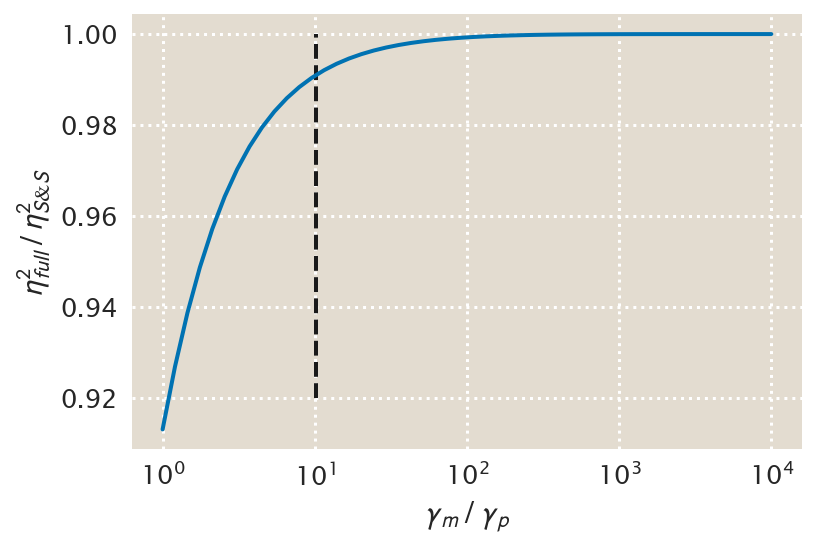

In [16]:
# Define a range of gm / gp ratios
gamma = np.logspace(0, 4) # gm / gp

# Copy the UV5 parameters and modify gp
par = par_UV5.copy()
par['gp'] = par['gp'] / gamma
par['rp'] = 1000 * par['gp']

# Plot the ratio of noises
plt.plot(gamma, noise_square_unreg(mRNA=False, **par) /
         noise_square_unreg_swain(**par))

# Indicate with vertical line the most likely value of the gm / gp ratio
plt.vlines(par_UV5['gm'] / par_UV5['gp'], 0.92, 1, linestyle='--')

# Label plot
plt.xscale('log')
plt.xlabel(r'$\gamma_m \; / \; \gamma_p$')
_ = plt.ylabel(r'$\eta^2_{full} \; / \; \eta^2_{S&S}$')

From this plot we can see that Shahrezaei & Swain's approximation works the best as the assumption of $\gm \gg \gp$ is better satisfied. From the vertical line we can see that for our assumption the approximation is already very accurate.

### Varying the $\gm / \gp$ ratio

An interesting question is now how much the ratio $\gm / \gp$ affects this noise. Let's plot the noise as we scale this ratio. 

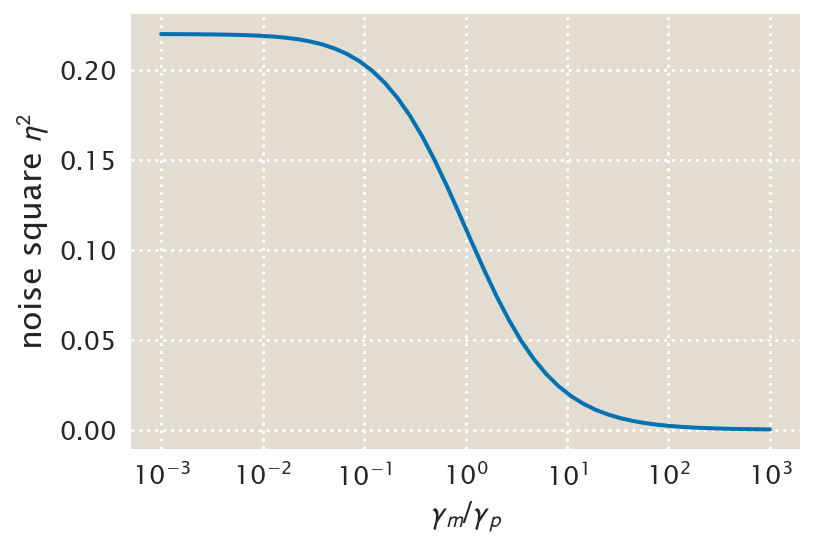

In [55]:
# Define array of gp values to explore
gamma_array = np.logspace(-3, 3)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
noise_square_var_gamma = np.empty_like(gp_array)
# Loop through gp values
for i, gamma in enumerate(gamma_array):
    # Update parameters
    par['gm'] = par_UV5['gp'] * gamma
    par['kp_on'] = par_UV5['kp_on'] * par['gm']
    par['kp_off'] = par_UV5['kp_off'] * par['gm']
    par['rm'] = par_UV5['rm'] * par['gm']
    # rp/gp is the average number of protein/mRNA
    par['rp'] = 1000 * par_UV5['gp'] 
    # Compute and save noise
    noise_square_var_gamma[i] = noise_square_unreg_p(**par)

plt.plot(gamma_array, noise_square_var_gamma)
plt.xlabel(r'$\gamma_m / \gamma_p$')
plt.ylabel(r'noise square $\eta^2$')
plt.xscale('log')

This ratio of degradation rates does have an effect in the noise at the protein level.

Since we do not know with certainty the value of these degradation rates, let's try to obtain a good estimate for this ratio given our experimental data.

### Estimating the $\gm / \gp$ ratio from experimental data.

Given the data that we have on unregulated promoters we can try to estimate the ratio of the degradation rates $\gm / \gp$. For this we will import the single-cell microscopy data for the $\Delta$*lacI* strains and compute the noise-squaare $\eta^2$.

In [73]:
# Define directory where data is stored
expdir = '../../data/microscopy/'

# Define directory where the bootstrap data was stored
bootsdir = '../channcap_exp/'

# List files of data taken exclusively for this experiment
bootsfiles = [x for x in os.listdir(bootsdir) 
              if ('channel_capacity_experiment' in x) &
              ('ipynb' not in x)]

# Extract dates for these experiments
project_dates = [x.split('_')[0] for x in bootsfiles]


# List files with the bootstrap sampling of the
files = glob.glob(expdir + '*csv')

files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files

# Extract dates from these files
file_dates = [file.split('/')[-1] for file in files]
file_dates = [file.split('_')[0] for file in file_dates]

# Filter for files taken exclusively for this experiment.
files = [file for i, file in enumerate(files) if file_dates[i] in project_dates]

df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files)

# Separate the auto and delta strains
df_delta = df_micro[(df_micro['rbs'] == 'auto') |
                    (df_micro['rbs'] == 'delta')]

df_delta[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


Let's now compute the noise square $\eta^2$

In [74]:
# group by date and by IPTG concentration
df_group = df_delta.groupby(['date', 'IPTG_uM'])

# Initialize data frame to save the noise
df_delta_noise = pd.DataFrame(columns=['date', 'operator', 'binding_energy',
                                      'mean_intensity', 'variance', 
                                       'noise_square'])
for (date, c), data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    delta_data = data[data.rbs == 'delta']
    
    # Append the require info
    delta_info = [date, delta_data.operator.unique()[0],
                   delta_data.binding_energy.unique()[0],
                  (delta_data.mean_intensity - I_auto).mean(), 
                  (delta_data.mean_intensity - I_auto).var(ddof=1)]
    # Compute the noise
    delta_info.append(delta_info[-1] / delta_info[-2]**2)
    # Convert to a pandas series to attach to the dataframe
    delta_info = pd.Series(delta_info, index=['date', 'operator', 
                                              'binding_energy', 
                                              'mean_intensity',
                                              'variance', 'noise_square'])
    # Append to the info to the data frame
    df_delta_noise = df_delta_noise.append(delta_info, ignore_index=True)
    
df_delta_noise.tail()

,date,operator,binding_energy,mean_intensity,variance,noise_square
7,20180321,O2,-13.9,2824.722626,1.304615e+06,0.163505
8,20180326,O2,-13.9,2419.937410,5.919979e+05,0.101091
9,20180326,O2,-13.9,2446.035749,5.125456e+05,0.085666
10,20180327,O3,-9.7,2803.400709,1.663008e+06,0.211604
11,20180327,O3,-9.7,2185.627027,5.592565e+05,0.117074


Let's now define a function that computes the residuals between the theoretical and the experimental value in order to find the ratio of degradation rates that better fits the available data.

In [61]:
def resid(gamma, noise_square_exp, unreg_par):
    '''
    Computes the residuals of the theoretical and the experimental noise-square
    for a two-state unregulated promoter
    '''
    par = unreg_par.copy()
    
    # Update parameters
    par['gm'] = unreg_par['gp'] * gamma
    par['kp_on'] = unreg_par['kp_on'] * par['gm']
    par['kp_off'] = unreg_par['kp_off'] * par['gm']
    par['rm'] = unreg_par['rm'] * par['gm']
    par['rp'] = 1000 * unreg_par['gp']
    # Compute and save noise
    return  noise_square_exp - noise_square_unreg_p(**par)

In [63]:
# Copy the parameters from the lacUV5 promoter
par = par_UV5.copy()

# Initial guess for the gm / gp ratio
p0 = 100

popt = sp.optimize.least_squares(resid, p0, 
       args=(df_delta_noise.noise_square.values, par))
popt.x

array([ 0.224307])

This number that we are obtaining does not make sense. We know that the protein has a much longer life-time than mRNA so we expected the ratio of degradation rates to be much larger than 1.

If we were to consider that this ratio $\gm / \gp$ is of order 10, then assumed that the microscopy reading added a constant noise such that these measurements were of the form
$$
\eta_{\text{data}}^2 = \eta_{\text{measurement}}^2 +
                       \eta_{\text{gene expression}}^2,
$$
where $\eta_{\text{measurement}}^2$ is the constant noise added by the microscope and $\eta_{\text{gene expression}}^2$ is the intrinsic noise given by the physics of gene expression, we could have that $\eta_{\text{measurement}}^2$ from this data.

In [64]:
# Copy the parameters
par = par_UV5.copy()
# Define the ratio gm / gp
gamma = 10
    
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']

df_delta_noise.noise_square.mean() -  noise_square_unreg_p(**par)

0.16230074477003661

### The effect of the protein production rate $\rm$ on the noise

Another interesting explanation for this deviation...

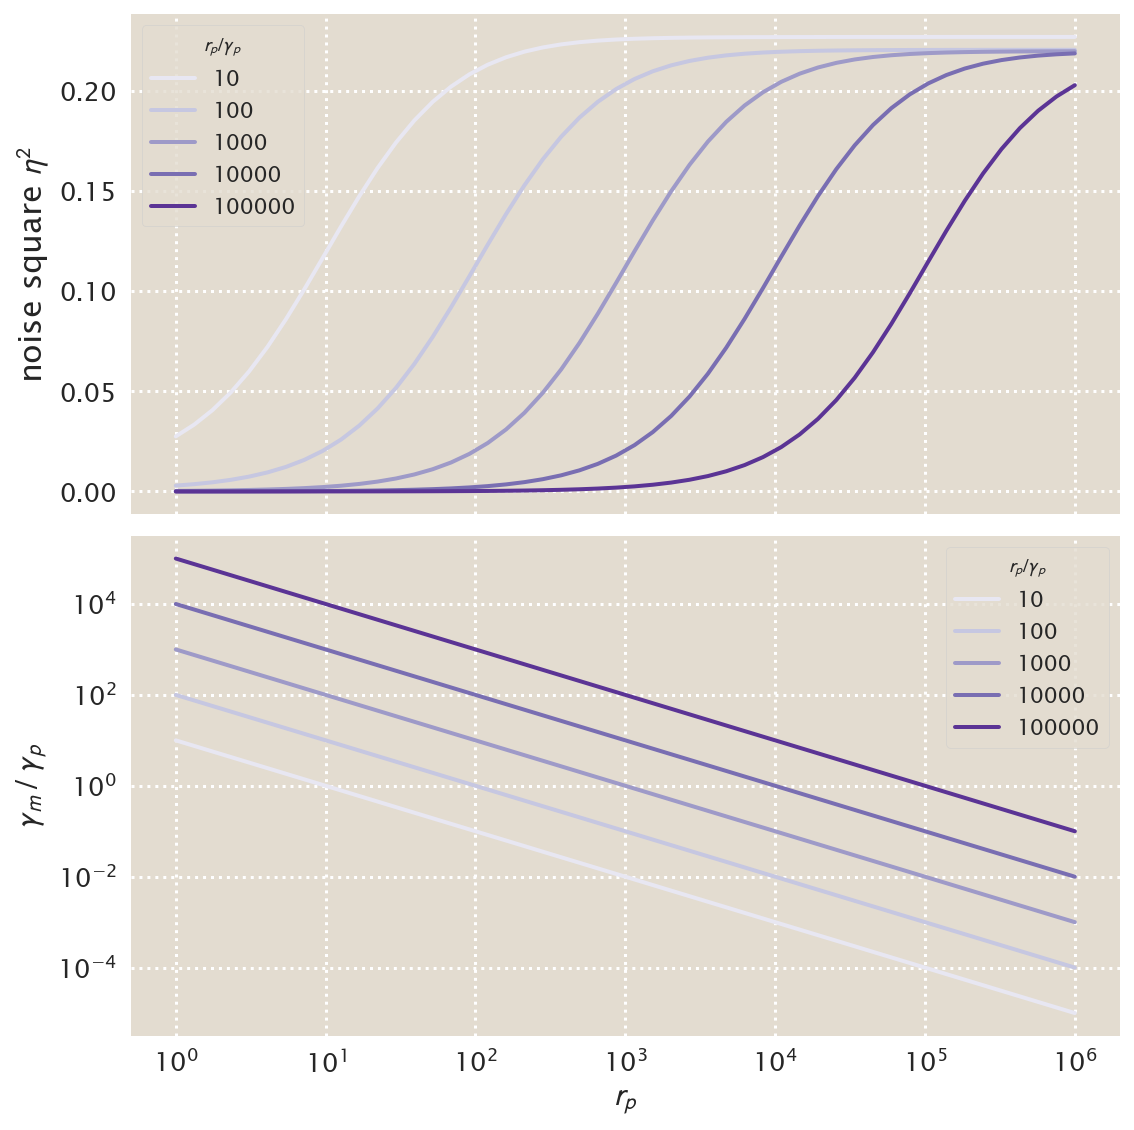

In [102]:
# Define array of gp values to explore
rp_array = np.logspace(0, 6)

# Define different rp / gp ratios
rp_gp_ratio = np.logspace(1, 5, 5).astype(int)

# Define colors
colors = sns.color_palette('Purples', n_colors=len(rp_gp_ratio))

# Initialize array to save noise values
noise_square_var_rp = np.empty([len(rp_array), len(rp_gp_ratio)])
# Initialize array to save gm/gp values
gm_gp = np.empty_like(noise_square_var_rp)

# Initialize plot
fig, ax = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Loop through rp / gp ratios
for j, rp_gp in enumerate(rp_gp_ratio):
    # Copy parameters dictionary
    par = par_UV5.copy()

    # Loop through rp values
    for i, rp in enumerate(rp_array):
        
        # Update parameters
        par['rp'] = rp
        par['gp'] = rp / rp_gp

        # Compute and save noise
        noise_square_var_rp[i, j] = noise_square_unreg_p(**par)
        # Comput and save gm / gp
        gm_gp[i, j] = par['gm'] / par['gp']

    ax[0].plot(rp_array, noise_square_var_rp[:, j], label=str(rp_gp),
             color=colors[j])
    ax[1].plot(rp_array, gm_gp[:, j], label=str(rp_gp),
             color=colors[j])
    
ax[0].set_ylabel(r'noise square $\eta^2$')
ax[0].legend(title=r'$r_p / \gamma_p$')
ax[0].set_xscale('log')

ax[1].set_xlabel(r'$r_p$')
ax[1].set_ylabel(r'$\gamma_m\; /\; \gamma_p$')
ax[1].legend(title=r'$r_p / \gamma_p$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

plt.tight_layout()

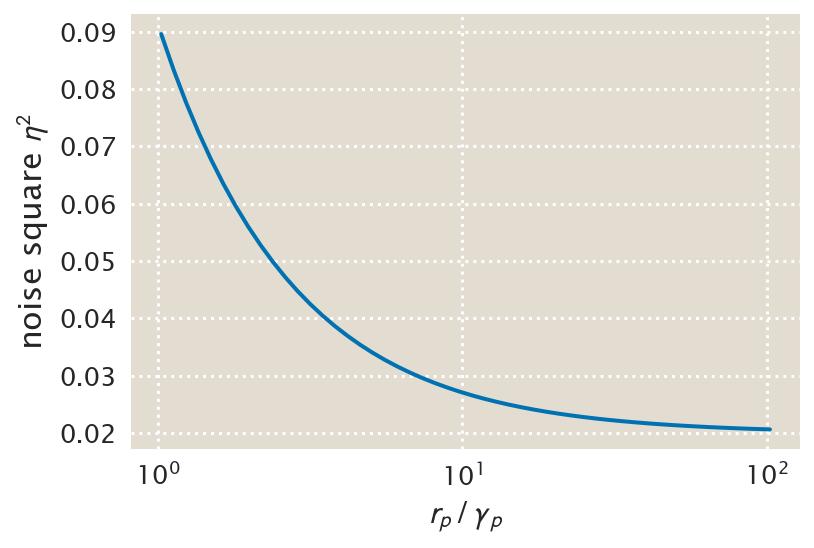

In [109]:
# Define array of gp values to explore
rp_array = np.logspace(-1, 1)

# Copy parameters dictionary
par = par_UV5.copy()

# Initialize array to save fano factor values
noise_square_var_rp = np.empty_like(rp_array)

# Loop through gp values
for i, rp in enumerate(rp_array):
    # Update parameters
    par['rp'] = rp
    # Compute and save noise
    noise_square_var_rp[i] = noise_square_unreg_p(**par)

plt.plot(rp_array / par['gp'], noise_square_var_rp)
plt.xlabel(r'$r_p\; /\; \gamma_p$')
plt.ylabel(r'noise square $\eta^2$')
plt.xscale('log')

## Explore the noise for the regulated three-state promoter.

Let's now explore how the noise scales as the repressor copy number. The way that the repressor copy number enters the kinetic scheme is by assuming that the $\kron$ rate is a diffusion limited rate of the form
$$
\kron = k_o \left[ R \right].
$$
The constant $k_o$ was indirectly inferred by the Sunney Xie lab and quoted by Jones and Brewster as $k_o = 2.7 \times 10^{-3} (\text{s nM})^{-1}$.

The value of $\kroff$ is then constrained by the value of the binding energy as inferred using equilibrium statistical mechanics. For the stat. mech. framework we have that the fold-change in gene expression is given by
$$
\foldchange = \frac{1}{1 + \frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r}},
$$
where $R$ is the absolute copy number of repressors per cell, $N_{NS}$ is the number of non-specific binding sites for the repressors (in our case the entire *E. coli genome* $4.6 \times 10^6$), $\beta$ is the inverse temperature times the Boltzmann constant and $\Delta \epsilon_r$ is the binding energy of the repressor to the operator binding site.

In the case of the three-state promoter the fold-change is given by
$$
\foldchange = {1 \over 1 + {\kron \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}
            = {1 \over 1 + {k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right)}.
$$

Given that these two equation have the same functional form we can conclude that
$$
\frac{R \cdot p_{act}}{N_{NS}} e^{-\beta \Delta \epsilon_r} =
{k_o [R] p_{act} \over \kroff} 
               \left( {\kpoff \over \kpoff + \kpon} \right).
$$
If we solve for $\kroff$ and convert the absolute number or repressors $R$ into a concentration $[R]$ we find that
$$
\kroff = 1.66 \cdot k_0 \cdot N_{NS} e^{\beta \Delta \epsilon_r}
          \left( {\kpoff \over \kpoff + \kpon} \right).
$$

Given this result let's define a function that computes $\kroff$ as a function of the binding energies and the RNAP rates.

In [59]:
def kr_off_fun(eRA, k0=2.7E-3, kp_on=0.017, kp_off=0.132, Nns=4.6E6):
    '''
    Returns the off rate of the repressor as a function of the stat. mech. 
    binding energy and the RNAP on and off rates
    Parameters
    ----------
    eRA : float.
        Repressor binding energies [kbT]
    k0 : float.
        Diffusion limited constant [s**-1 nM**-1]
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    Returns
    -------
    Repressor off rate
    '''
    return 1.66 * k0 * Nns * np.exp(eRA) * kp_off / (kp_off + kp_on)

Let's now define a function that computes the noise square $\eta^2$ for the regulated promoter as a function of repressor copy number and inducer concentration. For this we will assume that the number of active repressors is given by the equilibrium value as determiend by $R_{act} = R \cdot p_{act}$, where $p_{act}$ is given by the MWC model.

In [60]:
def noise_square_reg_p(C, rep, eRA, rm, gm, rp, gp,
                k0=2.7E-3, kp_on=0.017, kp_off=0.132, Nns=4.6E6,
                ka=139, ki=0.53, epsilon=4.5):
    '''
    Computes the noise square in protein copy number (variance / mean**2)
    as a function  of all the parameters that go into the chemical master 
    equation.
    
    Parameters
    ----------
    C : array-like.
        Concentration at which evaluate the probability.
    rep: float.
        repressor copy number per cell.
    eRA : float.
        Repressor binding energy [kBT]
    rm : float.
        transcription initiation rate. [time**-1]
    gm : float.
        mRNA degradation rate. [time**-1]
    rp : float.
        translation initiation rate. [time**-1]
    gp : float.
        protein degradation rate. [time**-1]
    k0 : float.
        diffusion limited rate of a repressor binding the promoter
    kp_on : float.
        RNAP on rate. [time**-1]
    kp_off : float.
        RNAP off rate. [time**-1]
    Nns : float.
        Number of non-specific binding sites
    ki, ka : float.
        dissociation constants for the inactive and active states respectively
        in the MWC model of the lac repressor.
    epsilon : float.
        energetic barrier between the inactive and the active state.
        
    Returns
    -------
    eta the noise in protein distribution
    '''
    # Convert C into np.array
    C = np.array(C)
    
    # Calculate the repressor on rate including the MWC model
    kr_on = k0 * rep * chann_cap.p_act(C, ka, ki, epsilon)
    # Compute the repressor off-rate based on the on-rate and the binding energy
    kr_off = kr_off_fun(eRA, k0, kp_on, kp_off, Nns)
    
    return second_reg_p(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp) /\
           first_reg_p(kr_on, kr_off, kp_on, kp_off, rm, gm, rp, gp)**2 - 1

### Noise for varying repressor copy number

Now that we have this function let's compute the noise for varying number of repressors at fix binding energy.

Text(0.5,1,'operator O1')

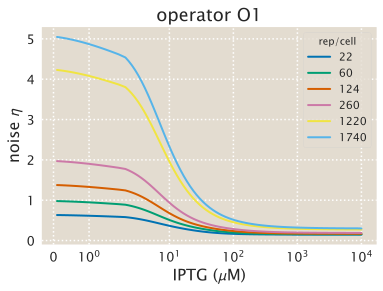

In [63]:
# Copy the parameters fit for the lacUV5 promoter
par = par_UV5.copy()
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par['k0'] = k0_norm

# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)

# Define the repressor copy numbers to use
repressors = [22, 60, 124, 260, 1220, 1740]
# Define the binding energy
eRA = -15.3

# Update it according to the gm/gp ratio
# (useful when exploring different ratios)
gamma = par_UV5['gm'] / par_UV5['gp']
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['eRA'] = eRA

for rep in repressors:
    par['rep'] = rep
    noise_square = noise_square_reg_p(IPTG, **par)
    plt.plot(IPTG, np.sqrt(noise_square), label='{:d}'.format(rep))

plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='rep/cell')
plt.title('operator O1')


### Noise for varying binding energy

Let's now compute the noise for varying binding energy at fix repressor copy number

Text(0.5,1,'$R = 260$ rep/cell')

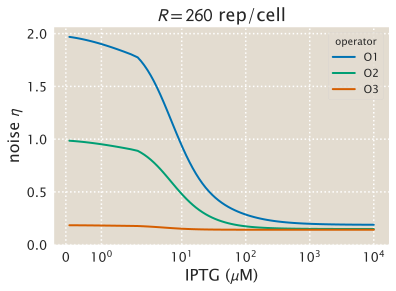

In [65]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)
# Define the repressor copy numbers to use
energies = dict(zip(['O1', 'O2', 'O3'], [-15.3, -13.9, -9.7]))

# Copy parameter set and update it according to the gm/gp ratio
par = par_UV5.copy()
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par['k0'] = k0_norm

# Update it according to the gm/gp ratio
# (useful when exploring different ratios)
gamma = par_UV5['gm'] / par_UV5['gp']
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['rep'] = 260

for energy, eRA in energies.items():
    par['eRA'] = eRA
    noise_square = noise_square_reg_p(IPTG, **par)
    plt.plot(IPTG, np.sqrt(noise_square), label='{:s}'.format(energy))

plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.ylim(bottom=0)
plt.legend(title='operator')
plt.title(r'$R = 260$ rep/cell')

# Testing three-state model with experimental data.

Let's now see how the three-state model performs when trying to predict the experimental noise measured with microscopy for different repressor copy numbers, binding energies and inducer concentrations.

First let's load the data.

In [66]:
# Read the tidy-data frame
files = glob.glob('../../data/csv_microscopy/*csv')# + mwc_files
df_micro = pd.concat(pd.read_csv(f, comment='#') for f in files if 'Oid' not in f)
df_micro[['date', 'operator', 'rbs', 'mean_intensity']].head()

,date,operator,rbs,mean_intensity
0,20161204,O3,auto,52.562979
1,20161204,O3,auto,53.070565
2,20161204,O3,auto,52.323744
3,20161204,O3,auto,51.013142
4,20161204,O3,auto,44.325267


Now let's compute the noise square $\eta^2$.

In [67]:
# group by date and by IPTG concentration
df_group = df_micro.groupby(['date'])

# Initialize data frame to save the noise
var = ['date', 'IPTG_uM','operator', 'binding_energy', 'rbs', 'repressors', 
       'mean', 'std', 'noise_square']
df_noise = pd.DataFrame(columns=var)
for date, data in df_group:
    # Extract the mean autofluorescence
    I_auto = data[data.rbs == 'auto'].mean_intensity.mean()
    
    # Extract the strain fluorescence measurements
    strain_data = data[(data.rbs != 'auto') & (data.rbs != 'delta')]
    
    # Group data by IPTG measurement
    data_group = strain_data.groupby('IPTG_uM')
    for inducer, data_inducer in data_group:
        # Append the require info
        strain_info = [date, inducer, data_inducer.operator.unique()[0],
                       data_inducer.binding_energy.unique()[0],
                       data_inducer.rbs.unique()[0],
                       data_inducer.repressors.unique()[0] * 2,
                      (data_inducer.mean_intensity - I_auto).mean(), 
                      (data_inducer.mean_intensity - I_auto).var(ddof=1)]
        # Compute the noise
        strain_info.append(strain_info[-1] / strain_info[-2]**2)
        # Convert to a pandas series to attach to the dataframe
        strain_info = pd.Series(strain_info, index=var)
        # Append to the info to the data frame
        df_noise = df_noise.append(strain_info, ignore_index=True)
    
df_noise.head()

,date,IPTG_uM,operator,binding_energy,rbs,repressors,mean,std,noise_square
0,20161118,0.0,O2,-13.9,RBS1027,260,28.660991,1175.976490,1.431582
1,20161118,0.1,O2,-13.9,RBS1027,260,29.234495,1210.486104,1.416344
2,20161118,5.0,O2,-13.9,RBS1027,260,71.514148,2829.580422,0.553271
3,20161118,10.0,O2,-13.9,RBS1027,260,129.849144,7627.019220,0.452352
4,20161118,25.0,O2,-13.9,RBS1027,260,391.288683,57668.980651,0.376658


Let's now plot the noise as a function of inducer concentration for each of the measured strains.

(-0.5, 8402.7716270925066)

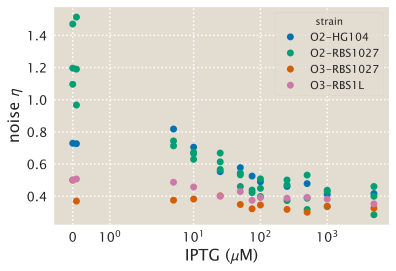

In [68]:
# Group data frame by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])
    
# Loop through groops plotting the noise as a function of IPTG concentration
for group, data in df_group:
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square), lw=0, marker='o',
            label='{0:s}-{1:s}'.format(group[0], group[1]))
# Label the plot
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)

### Testing the parameters

Let's now test the parameters that we think are the best guess given all of the combined experimental evidence so far.

(-0.5, 17398.189457156805)

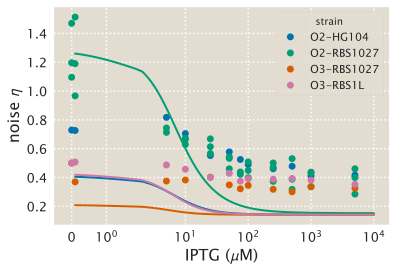

In [69]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)

# Copy the parameters fit for the lacUV5 promoter
par = par_UV5.copy()
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par['k0'] = k0_norm

# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))

i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    par['eRA'] = data.binding_energy.unique()[0]
    # Indicate the repressor copy number
    par['rep'] = data.repressors.unique()[0] * 1.66
    
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = np.sqrt(noise_square_reg_p(IPTG, **par))
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square.values), 
             lw=0, marker='o', label='{0:s}-{1:s}'.format(group[0], group[1]),
             color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
# plt.ylim(bottom=0)

IT seems that the theoretical predictions are systematically off the experimental data. But if we assume that the inferred discrepancy between our theoretical prediction and our experimental data for the unregulated promoter can be extended to the regulated case, we could add this extra noise to our theoretical predictions to see if that could account partially for this discrepancy.

(0, 1.5750402571984381)

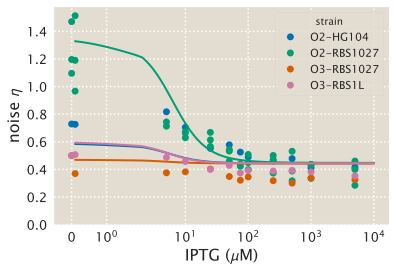

In [72]:
# Define the IPTG concentrations to evaluate the theoretical noise
IPTG = np.logspace(-1, 4, 100)

# Copy the parameters fit for the lacUV5 promoter
par = par_UV5.copy()
# Define the k0 parameters in units of the mRNA degradation time
k0_norm = 2.7E-3 / 0.00284 
par['k0'] = k0_norm

# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))

i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    par['eRA'] = data.binding_energy.unique()[0]
    # Indicate the repressor copy number
    par['rep'] = data.repressors.unique()[0] * 1.66
    
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = np.sqrt(noise_square_reg_p(IPTG, **par) + .177)
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square.values), 
             lw=0, marker='o', label='{0:s}-{1:s}'.format(group[0], group[1]),
             color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
plt.ylim(bottom=0)

The predictions are still off, but we need to obtain more data to properly asses this.

In [22]:
def resid(k0, gamma, df, reg_par, correction=.177):
    '''
    Computes the residuals of the theoretical and the experimental noise-square
    for a two-state unregulated promoter
    '''
    par = reg_par.copy()
    # Update parameters
    par['gm'] = reg_par['gp'] * gamma
    par['kp_on'] = reg_par['kp_on'] * par['gm']
    par['kp_off'] = reg_par['kp_off'] * par['gm']
    par['rm'] = reg_par['rm'] * par['gm']
    par['rp'] = 1000 * reg_par['gp']
    par['k0'] = k0 * par['gp']
    
    # Group by date and concentration
    noise_group = df.groupby(['date','IPTG_uM'])
    
    residuals = []
    # Loop through groups returning the residuals
    for group, data in noise_group:
        # Specify parameters for specific data set
        binding_energy = data.binding_energy.unique()[0]
        repressors = data.repressors.unique()[0]
        par['rep'] = 2 * 1.66 * repressors
        par['eRA'] = binding_energy
        par['C'] = group[1]
        # Compute experimental noise
        avg_noise = data.noise_square.values - correction
        # Append linear residuals
        residuals.append(noise_square_reg_p(**par) - avg_noise)
    
    return np.array(residuals).ravel()

In [128]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.858, kp_off=46.554, rm=124.706,
               gm=1, gp=1)

gamma = 10
# Initial guess for the k0 value
p0 = 1
df = df_noise[(df_noise.operator == 'O2') & (df_noise.rbs == 'RBS1027')]
popt = scipy.optimize.least_squares(resid, p0, 
       args=(gamma, df, par_UV5, .177))
popt.x

array([ 4437.33294678])

/Users/razo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


(-0.5, 17398.189457156805)

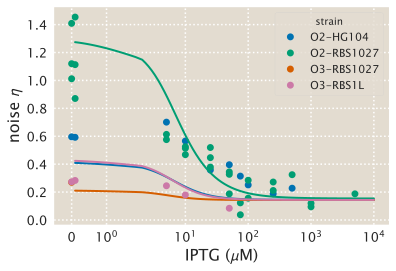

In [23]:
# List the parameters fit for the lacUV5 promoter
par_UV5 = dict(kp_on=5.5, kp_off=28.9, rm=87.6,
               gm=1, gp=1, k0=2.7E-3)

# Copy parameter set and update it according to the gm/gp ratio
par = par_UV5.copy()
gamma = 10
k0 = 10
# Update parameters
par['gm'] = par_UV5['gp'] * gamma
par['kp_on'] = par_UV5['kp_on'] * par['gm']
par['kp_off'] = par_UV5['kp_off'] * par['gm']
par['rm'] = par_UV5['rm'] * par['gm']
par['rp'] = 1000 * par_UV5['gp']
par['k0'] = k0 * par['gp']

# Group by operator and rbs
df_group = df_noise.groupby(['operator', 'rbs'])

colors = sns.color_palette('colorblind', n_colors=len(df_group))

i = 0
for group, data in df_group:
    # Extract energy and number of repressors
    par['eRA'] = data.binding_energy.unique()[0]
    # Indicate the repressor copy number
    par['rep'] = data.repressors.unique()[0] * 1.66 * 2
    
    # Compute the theoretical noise for different IPTG concentrations
    noise_thry = np.sqrt(noise_square_reg_p(IPTG, **par))
    # Plot the theoretical noise
    plt.plot(IPTG, noise_thry, color=colors[i])
    # Polot the experimental noise
    plt.plot(data.IPTG_uM, np.sqrt(data.noise_square.values - .177), 
             lw=0, marker='o', label='{0:s}-{1:s}'.format(group[0], group[1]),
             color=colors[i])
    i+=1
plt.xscale('symlog')
plt.xlabel('IPTG ($\mu$M)')
plt.ylabel('noise $\eta$')
plt.legend(title='strain')
plt.xlim(left=-5E-1)
# plt.ylim(bottom=0)